In [1]:
from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
import sys
import django
import os
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from itertools import product, combinations
from scipy.sparse import find

import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

from MulticoreTSNE import MulticoreTSNE as mTSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import coverage_error, label_ranking_average_precision_score, label_ranking_loss
from pycountry_convert import  country_alpha2_to_continent_code, country_alpha3_to_country_alpha2
import pickle
import scipy.sparse
import datetime
import scipy.stats as st
import scoping.utils.learning_utils as lu
from scoping.models import *
from utils.text import *
import matplotlib
import re
import igraph as ig

In [2]:
df = pd.read_csv('../data/all_categories.csv')

In [3]:
# Driver was coded only as an impact, its driver was uncoded
df.loc[df['id']==112762,"6 - 07 Aridity/dryness"] = 1
df.loc[df['id']==112762,"6 - 72 Conflict"] = 0
df.loc[df['id']==112762,"4 - 72 Conflict"] = 1
df.loc[df['id']==112762,"6 - 76 Human water use"] = 1

# Unspecific climate change driver not coded
df.loc[df['id']==746862,"6 - 13 Other (physical systems)"] = 1
df.loc[df['id']==746862,"4 - 72 Conflict"] = 1
df.loc[df['id']==746862,"4 - 73 Displacement and migration"] = 1

# Driver and impact wrong way round
df.loc[df['id']==2342058,"4 - 72 Conflict"] = 1
df.loc[df['id']==2342058,"6 - 07 Aridity/dryness"] = 1

# Crop yield miscoded as driver
df.loc[df['id']==377564,"4 - 69 Crop yields"] = 1
df.loc[df['id']==377564,"6 - 69 Crop yields"] = 0

# Phenology not also recognised as intermediary impact
df.loc[df['id']==2504903,"4 - 52 Shifts in phenology (Terrestrial and freshwater)"] = 1

#
df.loc[df['id']==325492,"6 - 36 Species distribution (marine & coastal)"] = 1

#
df.loc[df['id']==98654,'4 - 02 Air or land surface temperature changes'] = 0
df.loc[df['id']==98654,'4 - 05 Changes in precipitation'] = 0

#
df.loc[df['id']==561026,'4 - 02 Air or land surface temperature changes'] = 0
df.loc[df['id']==561026,'6 - 02 Air or land surface temperature changes'] = 1
df.loc[df['id']==561026,'4 - 66 Health'] = 1
#df.loc[df['id']==,] =


In [36]:
g = ig.Graph(directed=True)
cs = Category.objects.filter(project=178, title_only=False).exclude(name__icontains="<hidden>").order_by('name')
g.add_vertices(cs.filter(level=4).count())
g.vs["name"] = cs.filter(level=4).values_list('name',flat=True)
parents = []
for i,ic in enumerate(cs.filter(level=4)):
    ip = ic.equivalents.get(level=3).name
    parents.append(ip)
    for j, dc in enumerate(cs.filter(level=6)):
        jp = dc.equivalents.get(level=5).name
        if i==j:
            continue
        try:
            if ip == "3.1. Physical systems":
                n = df[(df[f"4 - {ic}"]==1) & (df[f"6 - {dc}"]==1) & (df[f"4 - {dc}"]==0)].shape[0]
            else:
                n = df[(df[f"4 - {ic}"]==1) & (df[f"6 - {dc}"]==1)].shape[0]
        except:
            n = 0
        if n > 1:
            g.add_edge(j,i,weight=n)
    
g.vs["parent"] = parents
#g = g.clusters().giant()
g.summary()

'IGRAPH DNW- 81 260 -- \n+ attr: name (v), parent (v), weight (e)'

In [106]:
g.summary()

'IGRAPH DNW- 81 260 -- \n+ attr: label (v), name (v), parent (v), weight (e)'

In [63]:
from matplotlib.colors import ListedColormap
from matplotlib import cm

parents = set(g.vs["parent"])

color_dict = dict(zip(parents,cm.get_cmap('Set2_r',len(parents)).colors))
color_dict = dict(zip(parents,['#7fc97f','#beaed4','#fdc086']))


In [105]:
l = g.layout()
#l = g.layout_reingold_tilford()
#l = g.layout_sugiyama()
#l = g.layout_drl()
#l = g.layout_kamada_kawai()
#l = g.layout_fruchterman_reingold(weights="weight")
#l = g.layout_davidson_harel()
g.vs["label"] = g.vs["name"]

visual_style = {}
visual_style["layout"] = l
visual_style["vertex_size"] = [5 + 0.05*x for x in g.strength(weights="weight")]
visual_style["edge_width"] = [0.2 + 0.1*x for x in g.es["weight"]]
visual_style["edge_arrow_size"] = [0.2 + 0.2*np.log(x) for x in g.es["weight"]]
visual_style["vertex_label_size"] = 8
visual_style["vertex_color"] = [list(color_dict[x]) for x in g.vs["parent"]]
#visual_style["bbox"] = (300,300)

ig.plot(g, **visual_style)

TypeError: '>' not supported between instances of 'str' and 'float'

In [55]:
x = g.vs["parent"][0]
f'rbga({",".join([str(y) for y in(color_dict[x])])})'

'rbga(0.4,0.7607843137254902,0.6470588235294118,1.0)'

In [89]:
parents

{'3.1. Physical systems',
 '3.2. Biological systems',
 '3.3. Human and managed systems'}

In [90]:
#x = column_dict.keys()[0]
groups = [[y.index for y in g.vs.select(parent=x)] for x in parents]
groups

[[38,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80],
 [35,
  36,
  37,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34]]

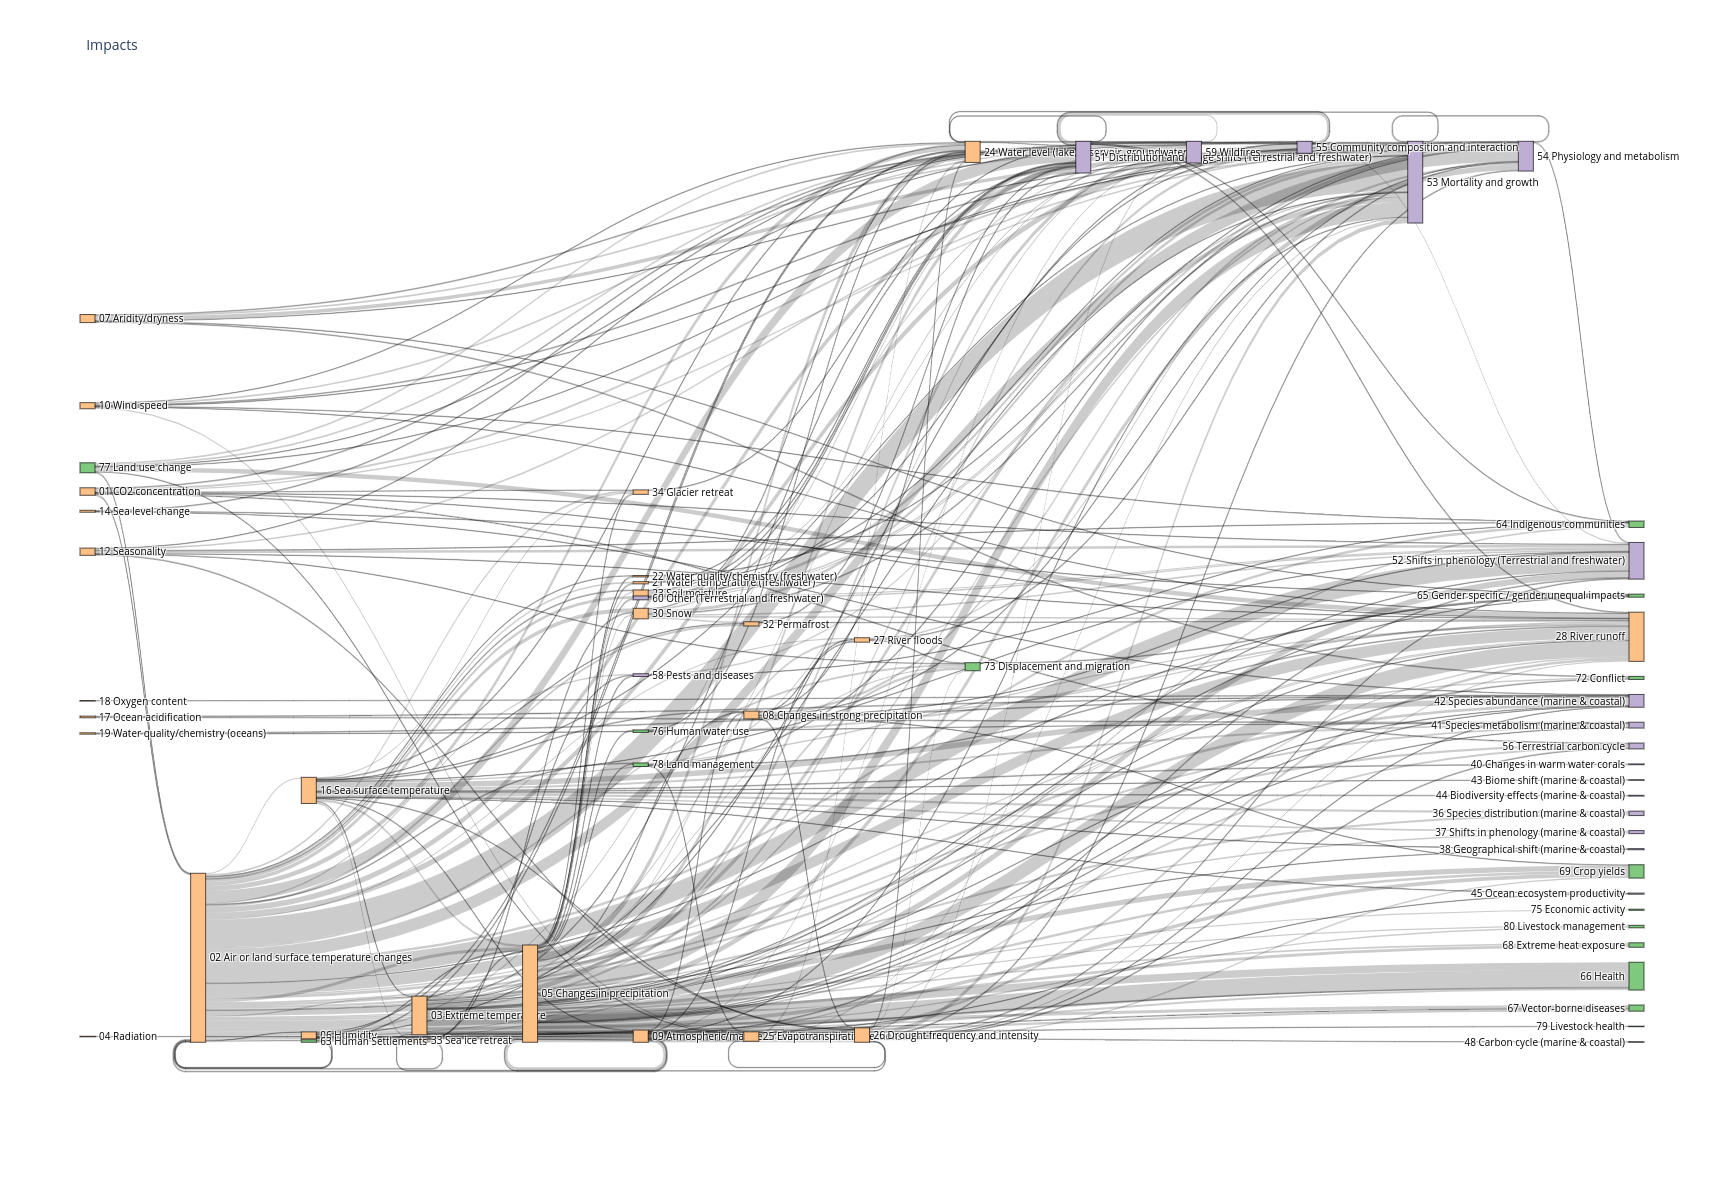

In [144]:
import plotly.graph_objects as go
import urllib, json

# override gray link colors with 'source' colors
opacity = 0.4
# change 'magenta' to its 'rgba' value to add opacity
data['data'][0]['node']['color'] = ['rgba(255,0,255, 0.8)' if color == "magenta" else color for color in data['data'][0]['node']['color']]
data['data'][0]['link']['color'] = [data['data'][0]['node']['color'][src].replace("0.8", str(opacity))
                                    for src in data['data'][0]['link']['source']]

column_dict = dict(zip(parents,[1,2,3]))

fig = go.Figure(data=[go.Sankey(
    valueformat = ".0f",
    #valuesuffix = "TWh",
    # Define nodes
    
    node = dict(
      pad = 15,
      thickness = 15,
      line = dict(color = "black", width = 0.5),
      label =  g.vs["name"],
      #label = [[y["name"] for y in g.vs.select(parent=x)] for x in parents],
      color = [color_dict[x] for x in g.vs["parent"]],
      #groups = groups,
      #groups = [1,2,3]
      #groups = [column_dict[x] for x in g.vs["parent"]]
      #x = [column_dict[x]*0.1 for x in g.vs["parent"]]
      #color =  [f'rgba({",".join([str(y) for y in(color_dict[x])])})' for x in g.vs["parent"]]
    ),
    # Add links
    link = dict(
      source =  [x.source for x in g.es],
      target =  [x.target for x in g.es],
      value =  g.es["weight"],
      #label =  data['data'][0]['link']['label'],
      #color =  [f'rgba({",".join([str(y) for y in(color_dict[x])])})' for x in g.vs["parent"]]
    )
    ,
    arrangement="snap",
)])

fig.update_layout(
    title_text="Impacts",
    font_size=10,
    width=1200,
    height=1200,
)
fig.show()

In [138]:
np.array([[1,2,3],[0,1,2]])[0][1]

2

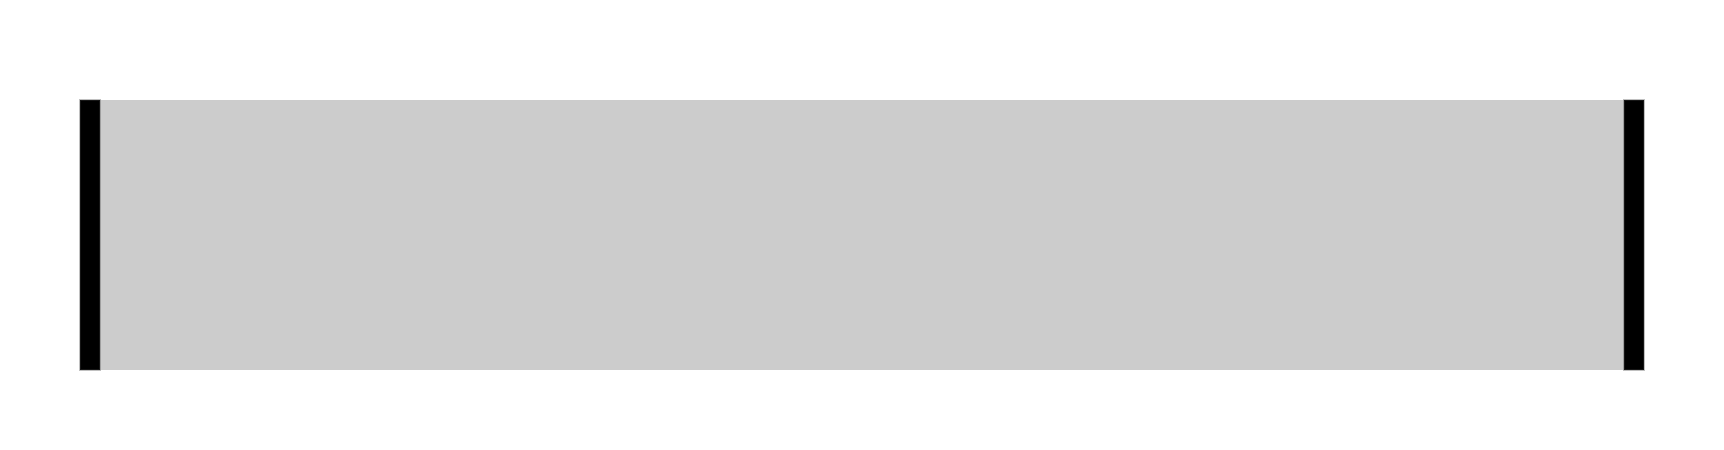

In [139]:
import plotly.graph_objects as go

fig = go.Figure(go.Sankey(
    arrangement = "snap",
    node = {
        "label": ["A", "B", "C"],
        #"x": [0.2, 0.1, 0.5, 0.7, 0.3, 0.5],
        #"y": [0.7, 0.5, 0.2, 0.4, 0.2, 0.3],
        "groups": [[0,1],[2]],
        'pad':10},  # 10 Pixels
    link = {
        "source": [0,  1],
        "target": [1,  2],
        "value": [1, 2]}))

fig.show()

In [44]:
df[(df["6 - 52 Shifts in phenology (Terrestrial and freshwater)"]==1)]

,Unnamed: 0,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant,12 - Coastal and marine Ecosystems,...,8 - 8.05. Quantitative - statistical,8 - 8.06. Qualitative - literature review,8 - 8.07. Qualitative - expert interviews,8 - 8.08. Qualitative - household surveys,8 - 8.09. Mixed methods,8 - 8.10. Case studies,8 - 8.11. Remote sensing,9 - observations,ca_rated,12 - Physical systems
71976,71976,209349,Spring migration of birds in many parts of the...,Ecological and life history correlates of chan...,Bird; Body size; Broodedness; Diet; Latitude; ...,['Environmental Sciences; Meteorology & Atmosp...,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
77388,77388,2504903,Trees exert a fundamental control on the hydro...,Possible Increases in Flood Frequency Due to t...,0,['Environmental Sciences; Limnology; Water Res...,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


In [45]:
c = '4 - 02 Air or land surface temperature changes'
c = "6 - 52 Shifts in phenology (Terrestrial and freshwater)"

for i, row in df.loc[(df[c]==1)].iterrows():
    print("\n",row['title'])
    print(row['content'])
    d = Doc.objects.get(pk=row['id'])
    print(d.id)
    print("impacts:")
    print(d.docusercat_set.filter(category__level=4).values('category__name','user__username'))
    print("drivers:")
    print(d.docusercat_set.filter(category__level=6).values('category__name','user__username'))


 Ecological and life history correlates of changes in avian migration timing in response to climate change
Spring migration of birds in many parts of the world has advanced as the climate has become warmer. Variation in advancement among species has been proposed to correlate with geography and life history features, but individual studies have reported variable results, and general patterns have been elusive. In a quantitative review of data from 389 bird species sampled at 69 European and 23 North American localities, we evaluated associations between change in the timing of migration and life history (body size, molt, broodedness), ecology (habitat, diet, nest position), and geography. We confirmed that spring migration advanced: -0.214 d yr(-1) (95% CI: -0.266, -0.162) for first-arriving individuals and -0.104 d yr(-1) (-0.139, -0.071) for the median date of passage. The rate of change in autumn was more variable: 0.090 d yr(-1) (0.002, 0.176) delay for median passage and 0.019 d 